# Custom Augmentations with Arithmetic Operations

This section shows you how to implement a custom augmentation by using expressions with arithmetic operations in the DALI Pipeline.

## Blending Images

We will create a pipeline that blends images in a few different ways. To easily visualize the results, we created the following file lists that contain pictures of cats and dogs:

 - `cats.txt` 
 
 - `dogs.txt`

#### Imports

Start with the necessary imports.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.types import Constant

### Explicitly Used Operators

1. The pipeline will use two `readers.file` to create two batches of tensors, one with cats and one with dogs.

2. We also need an `decoders.image` to decode the loaded images.

3. You need the `resize` operator for both inputs.

4. The arithmetic operators apply pointwise operations between tensors and require them to have matching shapes and sizes. 

   For this example, 400 x 400 images have been used.
   
5. The final operator that we may want to declare in the pipeline is a `Cast` operator to convert the data back into desired type.

### The Graph with Custom Augmentation

Here are initial steps:

1. Load both input batches.

2. Decode both inputs.

3. Resize the inputs to equal sizes.

Now, we have two variables `dogs` and `cats` that represent two batches of equal-sized images. 
We can blend those images with some weights and reduce the pixel intensities by half by using this formula:
```
(0.4 * cats + 0.6 * dogs) / 2
```
Here, we used Python immediate values as the constant inputs in the arithmetic expression.

#### Using dali.types.Constant to Indicate the Type
1. We can also be more careful about the types that we use, and do all of the computations in `uint16`.

The inputs are in `uint8`, and doing the computations with a constant that is marked as `uint16` promotes the results to `uint16`. See the "DALI binary arithmetic operators - type promotions" tutorial for more information.

2. We can also use the `//` division that allows us to keep the integer type of the result.

```
(Constant(4).uint16() * cats + Constant(6).uint16() * dogs) // Constant(20).uint16()
```

3. We return both of the inputs and the results have been casted back to `uint8`.

In [2]:
pipe = Pipeline(batch_size=1, num_threads=4, device_id=0, seed=42)
with pipe:
    cats_jpegs, _ = fn.readers.file(
        device="cpu", file_root="../../data/images", file_list="cats.txt"
    )
    dogs_jpegs, _ = fn.readers.file(
        device="cpu", file_root="../../data/images", file_list="dogs.txt"
    )
    images = fn.decoders.image(
        [cats_jpegs, dogs_jpegs], device="cpu", output_type=types.RGB
    )
    cats, dogs = fn.resize(images, resize_x=400, resize_y=400)
    blend_float = (0.4 * cats + 0.6 * dogs) / 2
    blend_uint16 = (
        Constant(4).uint16() * cats + Constant(6).uint16() * dogs
    ) // Constant(20).uint16()

    pipe.set_outputs(
        cats,
        dogs,
        fn.cast_like(blend_float, cats),
        fn.cast_like(blend_uint16, cats),
    )

### Running the Pipeline

1. Create an instance of the pipeline and build it. We use `batch_size = 1` for simplicity of showing the result.

In [3]:
pipe.build()

2. We will use a simple helper function to show the images. 

For larger batches, `data_idx` can be adjusted to show different samples.
The `output_titles` will be used to set the titles of the pipeline output.

In [4]:
import matplotlib.pyplot as plt


def display(output, titles, cpu=True):
    data_idx = 0
    fig, axes = plt.subplots(len(output) // 2, 2, figsize=(15, 15))
    if len(output) == 1:
        axes = [axes]
    for i, out in enumerate(output):
        img = out.at(data_idx) if cpu else out.as_cpu().at(data_idx)
        axes[i // 2, i % 2].imshow(img)
        axes[i // 2, i % 2].axis("off")
        axes[i // 2, i % 2].set_title(titles[i])


output_titles = [
    "Cat",
    "Dog",
    "(0.4 * Cat + 0.6 * Dog) / 2",
    "(Constant(4).uint16() * Cat + Constant(6).uint16() * Dog) // "
    "Constant(20).uint16()",
]

3. We will run and display the results.

You can play this cell several times to see the result for different images.

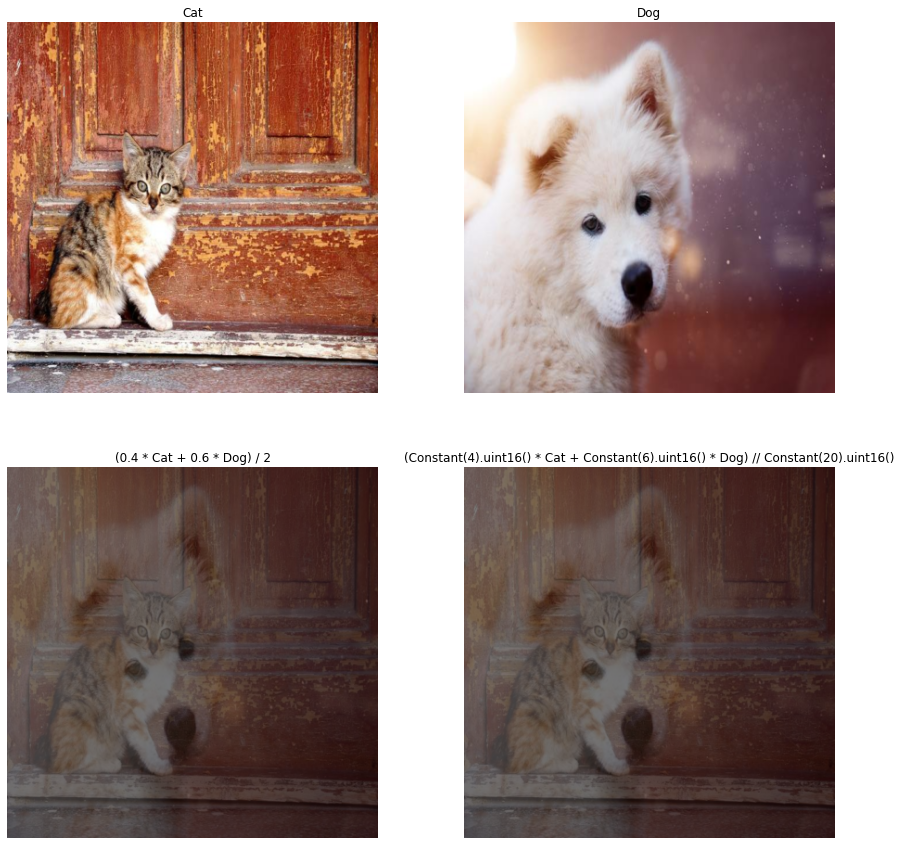

In [5]:
output = pipe.run()
display(output, output_titles)